In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from google.colab import drive
from pmdarima import auto_arima
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_excel('/content/Online_Retail_2.xlsx')
df = pd.read_excel('/content/drive/MyDrive/Online_Retail_2.xlsx')

In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [ ]:
df['Country'].value_counts()[:10]

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


In [ ]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [ ]:
df.nunique()

,0
InvoiceNo,25900
StockCode,4070
Description,4223
Quantity,722
InvoiceDate,23260
UnitPrice,1630
CustomerID,4372
Country,38


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df0=df

In [ ]:
df0.drop_duplicates(inplace=True)
df0 = df0.drop(['CustomerID', 'Description', 'InvoiceNo'], axis=1)
df0.dropna(inplace=True)
df0 = df0[df0['Quantity'] >= 0]
df0['InvoiceDate'] = pd.to_datetime(df0['InvoiceDate']).dt.date
df_grouped = df0.groupby(['StockCode', 'Country', 'InvoiceDate']).agg({'Quantity': 'sum', 'UnitPrice': 'mean'}).reset_index()


In [ ]:
df_grouped.shape

(305478, 5)

In [ ]:
df_grouped.head(10)

,StockCode,Country,InvoiceDate,Quantity,UnitPrice
0,10002,EIRE,2010-12-10,12,0.85
1,10002,France,2010-12-01,48,0.85
2,10002,France,2010-12-09,12,0.85
3,10002,France,2010-12-10,36,0.85
4,10002,France,2011-01-05,12,0.85
5,10002,France,2011-01-20,12,0.85
6,10002,France,2011-01-31,132,0.85
7,10002,France,2011-04-01,120,0.85
8,10002,Germany,2011-01-17,1,0.85
9,10002,Japan,2011-02-04,1,0.85


Text(0.5, 1.0, 'Top 5 Countries with the Most Invoices')

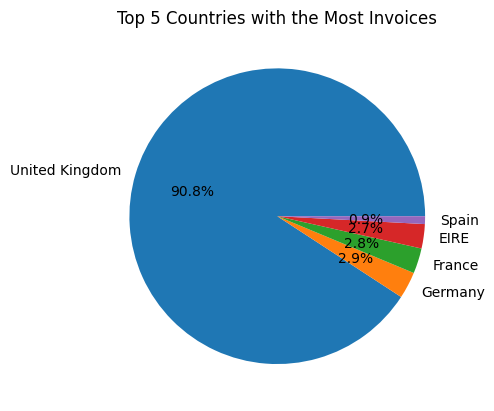

In [ ]:
import matplotlib.pyplot as plt

plt.pie(df_grouped['Country'].value_counts()[:5], labels=df_grouped['Country'].value_counts()[:5].index, autopct='%1.1f%%')
plt.title('Top 5 Countries with the Most Invoices')

In [ ]:
trail = df_grouped[(df_grouped['StockCode'] == '85123A') & (df_grouped['Country'] == 'United Kingdom')]
trail['InvoiceDate'] = pd.to_datetime(trail['InvoiceDate'])
idx = pd.date_range('2010-12-01', '2011-12-31')
trail.index = pd.DatetimeIndex(trail['InvoiceDate'])
trail = trail.reindex(idx)
trail.reset_index(inplace=True)
trail.drop('InvoiceDate', axis = 1, inplace=True)
trail.rename(columns={'index': 'InvoiceDate'}, inplace=True)


trail['StockCode'].fillna(trail['StockCode'].mode()[0], inplace=True)
trail['Country'].fillna(trail['Country'].mode()[0], inplace=True)


trail['Quantity'].fillna(trail['Quantity'].min(), inplace=True)
trail['UnitPrice'].fillna(trail['UnitPrice'].min(), inplace=True)


<ipython-input-45-780d25f5d186>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trail['InvoiceDate'] = pd.to_datetime(trail['InvoiceDate'])


In [ ]:
trail.head()

,InvoiceDate,StockCode,Country,Quantity,UnitPrice
0,2010-12-01,85123A,United Kingdom,454.0,3.086471
1,2010-12-02,85123A,United Kingdom,309.0,2.676316
2,2010-12-03,85123A,United Kingdom,25.0,3.372857
3,2010-12-04,85123A,United Kingdom,3.0,1.475000
4,2010-12-05,85123A,United Kingdom,198.0,2.888462


In [ ]:
Q1 = trail['Quantity'].quantile(0.25)
Q3 = trail['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5* IQR
trail.loc[(trail['Quantity'] <= lower_bound), 'Quantity']= lower_bound
trail.loc[(trail['Quantity'] >=upper_bound), 'Quantity']= upper_bound

In [ ]:
trail.set_index('InvoiceDate', inplace=True)

In [ ]:
from pmdarima import auto_arima
model1 = auto_arima(y=trail['Quantity'] ,start_p = 1, start_q = 1,
                          max_p = 5, max_q = 5, m = 15,
                          start_P = 0, seasonal = True,
                          max_P=8, D = 2, trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)

print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,2,1)[15]             : AIC=inf, Time=5.49 sec
 ARIMA(0,0,0)(0,2,0)[15]             : AIC=4740.373, Time=0.13 sec
 ARIMA(1,0,0)(1,2,0)[15]             : AIC=4580.804, Time=1.37 sec
 ARIMA(0,0,1)(0,2,1)[15]             : AIC=inf, Time=8.33 sec
 ARIMA(1,0,0)(0,2,0)[15]             : AIC=4742.373, Time=0.25 sec
 ARIMA(1,0,0)(2,2,0)[15]             : AIC=4516.657, Time=2.48 sec
 ARIMA(1,0,0)(3,2,0)[15]             : AIC=4469.574, Time=10.42 sec
 ARIMA(1,0,0)(4,2,0)[15]             : AIC=4439.144, Time=10.18 sec
 ARIMA(1,0,0)(5,2,0)[15]             : AIC=4427.971, Time=37.78 sec
 ARIMA(1,0,0)(6,2,0)[15]             : AIC=4409.444, Time=53.71 sec
 ARIMA(1,0,0)(7,2,0)[15]             : AIC=inf, Time=90.90 sec
 ARIMA(1,0,0)(6,2,1)[15]             : AIC=inf, Time=63.66 sec
 ARIMA(1,0,0)(5,2,1)[15]             : AIC=inf, Time=87.29 sec
 ARIMA(1,0,0)(7,2,1)[15]             : AIC=inf, Time=284.60 sec
 ARIMA(0,0,0)(6,2,0)[15]             : A

In [ ]:
train = trail.iloc[:len(trail)-60]
test = trail.iloc[len(trail)-60:]

model = SARIMAX(train['Quantity'], order=(1,0,0), seasonal_order=(6,2,0,15))

model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Quantity   No. Observations:                  336
Model:             SARIMAX(1, 0, 0)x(6, 2, 0, 15)   Log Likelihood               -1835.697
Date:                            Thu, 15 Aug 2024   AIC                           3687.394
Time:                                    07:11:29   BIC                           3717.183
Sample:                                12-01-2010   HQIC                          3699.308
                                     - 11-01-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1244      0.058      2.152      0.031       0.011       0.238
ar.S.L15      -1.3252      0.059    -22.426      0.000      -1.441      -1.209
ar.S.L30      -1.3274      0.101    -13.148      0.000      -1.525      -1.130
ar.S.L45      -1.2093      0.118    -10.212      0.000      -1.441      -0.977
ar.S.L60      -0.8819      0.122     -7.239      0.000      -1.121      -0.643
ar.S.L75      -0.5497      0.107     -5.148      0.000      -0.759      -0.340
ar.S.L90      -0.2660      0.060     -4.411      0.000      -0.384      -0.148
sigma2      8462.7882    732.963     11.546      0.000    7026.208    9899.369
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.78   Prob(JB):                         0.66
Heteroskedasticity (H):               0.76   Skew:                             0.09
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


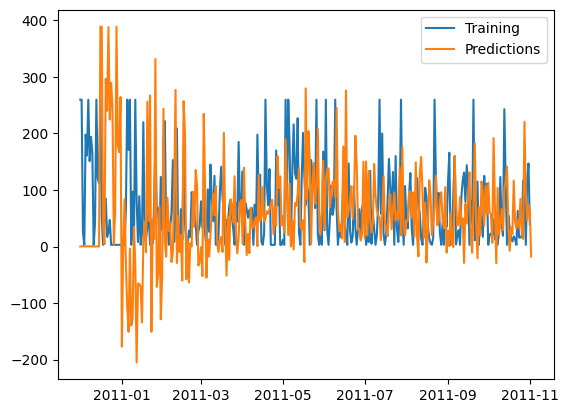

In [ ]:
start = 0
end = len(train)
predictions = model_fit.predict(start=start, end=end, type='levels')

plt.plot(train['Quantity'], label='Training')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Top 5 Stocks in UK')

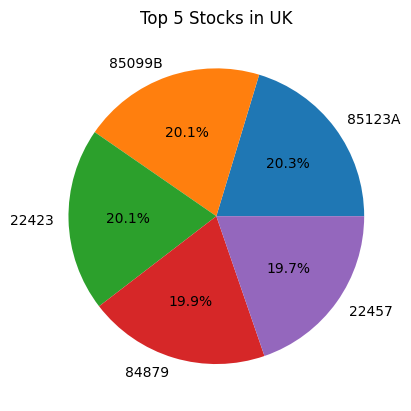

In [ ]:
df2 = df_grouped[df_grouped['Country'] == 'United Kingdom']
plt.pie(df2['StockCode'].value_counts()[:5], labels= df2['StockCode'].value_counts()[:5].index, autopct='%1.1f%%')
plt.title('Top 5 Stocks in UK')

In [ ]:
one = df2[(df2['StockCode'] == '85123A')]
two = df2[(df2['StockCode'] == '84406B')]
three = df2[(df2['StockCode'] == 22423)]
four = df2[(df2['StockCode'] == 84879)]
five = df2[(df2['StockCode'] == 22457)]

In [ ]:
one = df_grouped[(df_grouped['StockCode'] == '85123A') & (df_grouped['Country'] == 'United Kingdom')]
one['InvoiceDate'] = pd.to_datetime(one['InvoiceDate'])
idx = pd.date_range('2010-12-01', '2011-12-31')
one.index = pd.DatetimeIndex(one['InvoiceDate'])
one = one.reindex(idx)
one.reset_index(inplace=True)
one.drop('InvoiceDate', axis = 1, inplace=True)
one.rename(columns={'index': 'InvoiceDate'}, inplace=True)


one['StockCode'].fillna(one['StockCode'].mode()[0], inplace=True)
one['Country'].fillna(one['Country'].mode()[0], inplace=True)


one['Quantity'].fillna(one['Quantity'].min(), inplace=True)
one['UnitPrice'].fillna(one['UnitPrice'].min(), inplace=True)


# OUTLIERS
Q1 = one['Quantity'].quantile(0.25)
Q3 = one['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5* IQR
one.loc[(one['Quantity'] <= lower_bound), 'Quantity']= lower_bound
one.loc[(one['Quantity'] >=upper_bound), 'Quantity']= upper_bound

one.set_index('InvoiceDate', inplace=True)


train = one.iloc[:len(one)-60]
test = one.iloc[len(one)-60:]

model = SARIMAX(train['Quantity'], order=(1,1,0), seasonal_order=(6,2,0,15))

model_fit = model.fit()
print(model_fit.summary())

<ipython-input-60-3d8a38fbcb70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one['InvoiceDate'] = pd.to_datetime(one['InvoiceDate'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  336
Model:             SARIMAX(1, 1, 0)x(6, 2, 0, 15)   Log Likelihood               -1882.308
Date:                            Thu, 15 Aug 2024   AIC                           3780.616
Time:                                    07:29:35   BIC                           3810.378
Sample:                                12-01-2010   HQIC                          3792.520
                                     - 11-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.062     -7.514      0.000      -0.590      -0.346
ar.S.L15      -1.3070      0.058   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


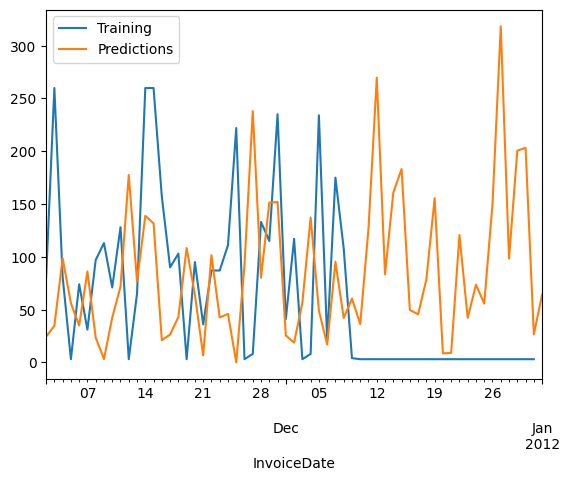

In [ ]:
start = len(train)
end = len(train)+len(test)
predictions = model_fit.predict(start=start, end=end, type='levels')

test['Quantity'].plot(label='Training')
predictions.plot(label='Predictions')
plt.legend()
plt.show()

In [ ]:
two = df_grouped[(df_grouped['StockCode'] == '85123A') & (df_grouped['Country'] == 'United Kingdom')]
two['InvoiceDate'] = pd.to_datetime(two['InvoiceDate'])
idx = pd.date_range('2010-12-01', '2011-12-31')
two.index = pd.DatetimeIndex(two['InvoiceDate'])
two = two.reindex(idx)
two.reset_index(inplace=True)
two.drop('InvoiceDate', axis = 1, inplace=True)
two.rename(columns={'index': 'InvoiceDate'}, inplace=True)


two['StockCode'].fillna(two['StockCode'].mode()[0], inplace=True)
two['Country'].fillna(two['Country'].mode()[0], inplace=True)


two['Quantity'].fillna(two['Quantity'].min(), inplace=True)
two['UnitPrice'].fillna(two['UnitPrice'].min(), inplace=True)


# OUTLIERS
Q1 = two['Quantity'].quantile(0.25)
Q3 = two['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5* IQR
two.loc[(two['Quantity'] <= lower_bound), 'Quantity']= lower_bound
two.loc[(two['Quantity'] >=upper_bound), 'Quantity']= upper_bound

two.set_index('InvoiceDate', inplace=True)


train = two.iloc[:len(two)-60]
test = two.iloc[len(two)-60:]

model = SARIMAX(train['Quantity'], order=(1,1,0), seasonal_order=(6,2,0,15))

model_fit = model.fit()
print(model_fit.summary())

<ipython-input-62-518efffd8f8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two['InvoiceDate'] = pd.to_datetime(two['InvoiceDate'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  336
Model:             SARIMAX(1, 1, 0)x(6, 2, 0, 15)   Log Likelihood               -1882.308
Date:                            Thu, 15 Aug 2024   AIC                           3780.616
Time:                                    07:30:35   BIC                           3810.378
Sample:                                12-01-2010   HQIC                          3792.520
                                     - 11-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.062     -7.514      0.000      -0.590      -0.346
ar.S.L15      -1.3070      0.058   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


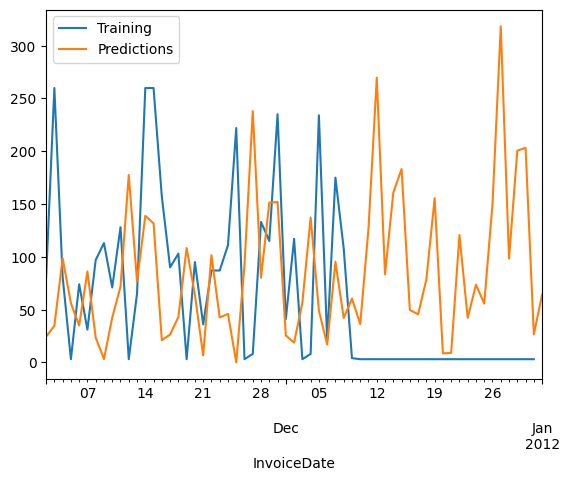

In [ ]:
start = len(train)
end = len(train)+len(test)
predictions = model_fit.predict(start=start, end=end, type='levels')

test['Quantity'].plot(label='Training')
predictions.plot(label='Predictions')
plt.legend()
plt.show()

In [ ]:
three = df_grouped[(df_grouped['StockCode'] == '85123A') & (df_grouped['Country'] == 'United Kingdom')]
three['InvoiceDate'] = pd.to_datetime(three['InvoiceDate'])
idx = pd.date_range('2010-12-01', '2011-12-31')
three.index = pd.DatetimeIndex(three['InvoiceDate'])
three = three.reindex(idx)
three.reset_index(inplace=True)
three.drop('InvoiceDate', axis = 1, inplace=True)
three.rename(columns={'index': 'InvoiceDate'}, inplace=True)


three['StockCode'].fillna(three['StockCode'].mode()[0], inplace=True)
three['Country'].fillna(three['Country'].mode()[0], inplace=True)


three['Quantity'].fillna(three['Quantity'].min(), inplace=True)
three['UnitPrice'].fillna(three['UnitPrice'].min(), inplace=True)


# OUTLIERS
Q1 = three['Quantity'].quantile(0.25)
Q3 = three['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5* IQR
three.loc[(three['Quantity'] <= lower_bound), 'Quantity']= lower_bound
three.loc[(three['Quantity'] >=upper_bound), 'Quantity']= upper_bound

three.set_index('InvoiceDate', inplace=True)


train = three.iloc[:len(three)-60]
test = three.iloc[len(three)-60:]

model = SARIMAX(train['Quantity'], order=(1,1,0), seasonal_order=(6,2,0,15))

model_fit = model.fit()
print(model_fit.summary())

<ipython-input-64-97e1be89e06f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three['InvoiceDate'] = pd.to_datetime(three['InvoiceDate'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  336
Model:             SARIMAX(1, 1, 0)x(6, 2, 0, 15)   Log Likelihood               -1882.308
Date:                            Thu, 15 Aug 2024   AIC                           3780.616
Time:                                    07:31:35   BIC                           3810.378
Sample:                                12-01-2010   HQIC                          3792.520
                                     - 11-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.062     -7.514      0.000      -0.590      -0.346
ar.S.L15      -1.3070      0.058   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


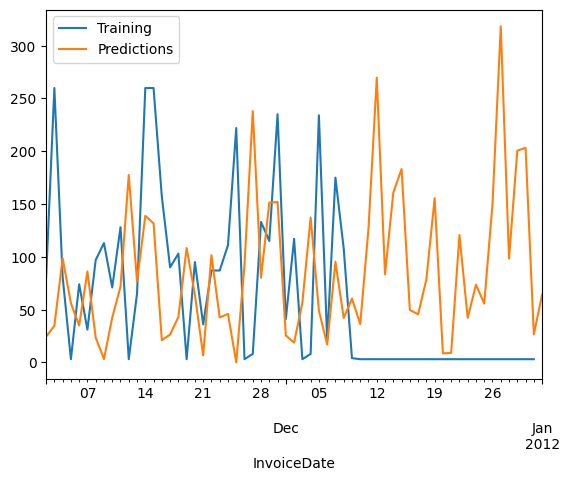

In [ ]:
start = len(train)
end = len(train)+len(test)
predictions = model_fit.predict(start=start, end=end, type='levels')

test['Quantity'].plot(label='Training')
predictions.plot(label='Predictions')
plt.legend()
plt.show()

In [ ]:
four = df_grouped[(df_grouped['StockCode'] == '85123A') & (df_grouped['Country'] == 'United Kingdom')]
four['InvoiceDate'] = pd.to_datetime(four['InvoiceDate'])
idx = pd.date_range('2010-12-01', '2011-12-31')
four.index = pd.DatetimeIndex(four['InvoiceDate'])
four = four.reindex(idx)
four.reset_index(inplace=True)
four.drop('InvoiceDate', axis = 1, inplace=True)
four.rename(columns={'index': 'InvoiceDate'}, inplace=True)


four['StockCode'].fillna(four['StockCode'].mode()[0], inplace=True)
four['Country'].fillna(four['Country'].mode()[0], inplace=True)


four['Quantity'].fillna(four['Quantity'].min(), inplace=True)
four['UnitPrice'].fillna(four['UnitPrice'].min(), inplace=True)


# OUTLIERS
Q1 = four['Quantity'].quantile(0.25)
Q3 = four['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5* IQR
four.loc[(four['Quantity'] <= lower_bound), 'Quantity']= lower_bound
four.loc[(four['Quantity'] >=upper_bound), 'Quantity']= upper_bound

four.set_index('InvoiceDate', inplace=True)


train = four.iloc[:len(four)-60]
test = four.iloc[len(four)-60:]

model = SARIMAX(train['Quantity'], order=(1,1,0), seasonal_order=(6,2,0,15))

model_fit = model.fit()
print(model_fit.summary())

<ipython-input-66-f7a1f0292e81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  four['InvoiceDate'] = pd.to_datetime(four['InvoiceDate'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  336
Model:             SARIMAX(1, 1, 0)x(6, 2, 0, 15)   Log Likelihood               -1882.308
Date:                            Thu, 15 Aug 2024   AIC                           3780.616
Time:                                    07:32:36   BIC                           3810.378
Sample:                                12-01-2010   HQIC                          3792.520
                                     - 11-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.062     -7.514      0.000      -0.590      -0.346
ar.S.L15      -1.3070      0.058   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


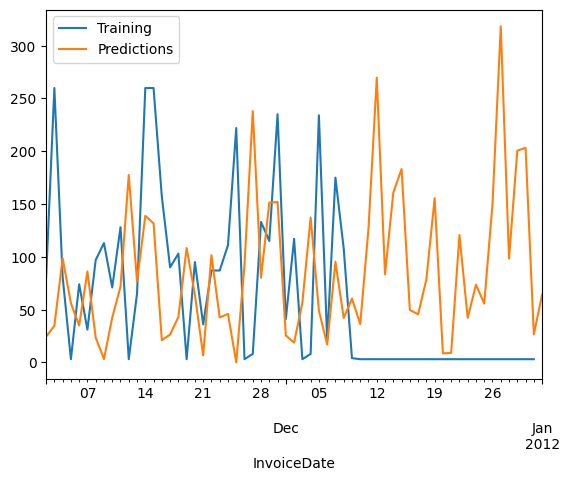

In [ ]:
start = len(train)
end = len(train)+len(test)
predictions = model_fit.predict(start=start, end=end, type='levels')

test['Quantity'].plot(label='Training')
predictions.plot(label='Predictions')
plt.legend()
plt.show()

In [ ]:
five = df_grouped[(df_grouped['StockCode'] == '85123A') & (df_grouped['Country'] == 'United Kingdom')]
five['InvoiceDate'] = pd.to_datetime(five['InvoiceDate'])
idx = pd.date_range('2010-12-01', '2011-12-31')
five.index = pd.DatetimeIndex(five['InvoiceDate'])
five = five.reindex(idx)
five.reset_index(inplace=True)
five.drop('InvoiceDate', axis = 1, inplace=True)
five.rename(columns={'index': 'InvoiceDate'}, inplace=True)


five['StockCode'].fillna(five['StockCode'].mode()[0], inplace=True)
five['Country'].fillna(five['Country'].mode()[0], inplace=True)


five['Quantity'].fillna(five['Quantity'].min(), inplace=True)
five['UnitPrice'].fillna(five['UnitPrice'].min(), inplace=True)


# OUTLIERS
Q1 = five['Quantity'].quantile(0.25)
Q3 = five['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5* IQR
five.loc[(five['Quantity'] <= lower_bound), 'Quantity']= lower_bound
five.loc[(five['Quantity'] >=upper_bound), 'Quantity']= upper_bound

five.set_index('InvoiceDate', inplace=True)


train = five.iloc[:len(five)-60]
test = five.iloc[len(five)-60:]

model = SARIMAX(train['Quantity'], order=(1,1,0), seasonal_order=(6,2,0,15))

model_fit = model.fit()
print(model_fit.summary())

<ipython-input-68-55f14fbe2ae8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five['InvoiceDate'] = pd.to_datetime(five['InvoiceDate'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  336
Model:             SARIMAX(1, 1, 0)x(6, 2, 0, 15)   Log Likelihood               -1882.308
Date:                            Thu, 15 Aug 2024   AIC                           3780.616
Time:                                    07:33:34   BIC                           3810.378
Sample:                                12-01-2010   HQIC                          3792.520
                                     - 11-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.062     -7.514      0.000      -0.590      -0.346
ar.S.L15      -1.3070      0.058   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


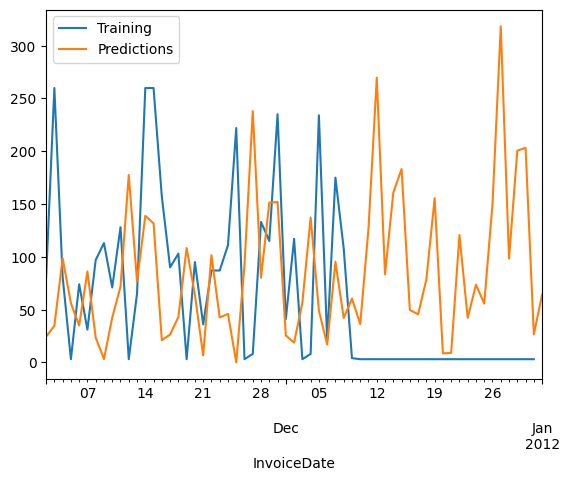

In [ ]:
start = len(train)
end = len(train)+len(test)
predictions = model_fit.predict(start=start, end=end, type='levels')

test['Quantity'].plot(label='Training')
predictions.plot(label='Predictions')
plt.legend()
plt.show()